In [77]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from pathlib import Path
import h5py

from IPython import display

In [78]:
data_dir = Path("../data/preprocessed")
train_images = np.load(data_dir / "GNILC_dust_map.npy").astype(np.float32)

In [94]:
LAT_DIM = 64

In [121]:
BUFFER_SIZE = 1034
BATCH_SIZE = 32

In [122]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [123]:
def make_generator_model():
    # Generator is sequential model
    model = tf.keras.Sequential(name="Generator")

    # First layer of generator is densely connected
    model.add(layers.Dense(16 * 16 * 512, input_shape=(64,), kernel_initializer='he_normal', name='Dense_G'))
    model.add(layers.Reshape((16, 16, 512), name='Reshape'))
    
    model.add(layers.BatchNormalization(momentum=0.9, name='BNorm_G1'))
    model.add(layers.LeakyReLU(alpha=0.2, name='LRelu_G1'))
    model.add(layers.UpSampling2D(2, name='UpSample_1', interpolation='bilinear'))
    model.add(layers.Conv2D(256, 5, strides=1, padding='same', kernel_initializer='he_normal', name='Conv2D_G1'))
    assert model.output_shape == (None, 32, 32, 256)
    
    model.add(layers.BatchNormalization(momentum=0.9, name='BN_G2'))    
    model.add(layers.LeakyReLU(alpha=0.2, name='LRelu_G2'))
    model.add(layers.UpSampling2D(2, name='UpSample_2', interpolation='bilinear'))
    model.add(layers.Conv2D(128, 5, strides=1, padding='same', kernel_initializer='he_normal', name='Conv2D_G2'))
    assert model.output_shape == (None, 64, 64, 128)
    
    model.add(layers.BatchNormalization(momentum=0.9, name='BN_G3'))    
    model.add(layers.LeakyReLU(alpha=0.2, name='LRelu_G3'))
    model.add(layers.UpSampling2D(2, name='UpSample_3', interpolation='bilinear'))
    model.add(layers.Conv2D(64, 5, strides=1, padding='same', kernel_initializer='he_normal', name='Conv2D_G3'))
    assert model.output_shape == (None, 128, 128, 64)
    
    model.add(layers.BatchNormalization(momentum=0.9, name='BN_G4'))    
    model.add(layers.LeakyReLU(alpha=0.2, name='LRelu_G4'))
    model.add(layers.UpSampling2D(2, name='UpSample_4', interpolation='bilinear'))
    model.add(layers.Conv2D(1, 5, strides=1, padding='same', kernel_initializer='he_normal', name='Conv2D_G4'))
    assert model.output_shape == (None, 256, 256, 1)
    
    model.add(layers.Activation('tanh', name='Tanh'))
    
    c_r = int((model.get_layer('Tanh').output_shape[1] - 256) / 2)
    c_c = int((model.get_layer('Tanh').output_shape[2] - 256) / 2)
    
    model.add(layers.Cropping2D(cropping=((c_c, c_c), (c_r, c_r)), name='Crop2D'))
    assert model.output_shape == (None, 256, 256, 1)
    return model

In [124]:
def make_discriminator_model():
    model = tf.keras.Sequential(name='Discriminator')
    
    model.add(layers.Conv2D(32, 5, strides=2, input_shape=(256, 256, 1), padding="same", kernel_initializer="he_normal", name="Conv2D_D1"))
    model.add(layers.LeakyReLU(alpha=0.2, name="LRelu_D1"))
    assert model.output_shape == (None, 128, 128, 32)

    model.add(layers.Conv2D(64, 5, strides=2, padding='same', kernel_initializer='he_normal', name="Conv2D_D2"))
    model.add(layers.BatchNormalization(momentum=0.9, name="BNorm_D2"))
    model.add(layers.LeakyReLU(alpha=0.2, name="LRelu_D2"))
    assert model.output_shape == (None, 64, 64, 64)
              
    model.add(layers.Conv2D(128, 5, strides=2, padding='same', kernel_initializer='he_normal', name="Conv2D_D3"))
    model.add(layers.BatchNormalization(momentum=0.9, name="BNorm_D3"))
    model.add(layers.LeakyReLU(alpha=0.2, name="LRelu_D3"))
    assert model.output_shape == (None, 32, 32, 128)
    
    model.add(layers.Flatten(name="Flatten"))
    model.add(layers.Dense(1, kernel_initializer='he_normal', name='Dense_D2'))
    model.add(layers.Activation('sigmoid', name='Sigmoid'))
    assert model.output_shape == (None, 1)
    return model

In [125]:
def discriminator_loss(real_output, fake_output):
    real_output_target = np.empty(real_output.shape)
    for i in range(real_output_target.shape[0]):
        real_output_target[i] = np.random.uniform(0.97, 1.0)
        if np.random.binomial(1, 0.01):
            real_output_target[i] = np.random.uniform(0., 0.03)
    fake_output_target = np.empty(fake_output.shape)
    for i in range(fake_output_target.shape[0]):
        fake_output_target[i] = np.random.uniform(0., 0.03)
        if np.random.binomial(1., 0.01):
            fake_output_target[i] - np.random.uniform(0.97, 1.0)
    real_loss = cross_entropy(real_output_target, real_output)
    fake_loss = cross_entropy(fake_output_target, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [126]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [127]:
generator = make_generator_model()
discriminator = make_discriminator_model()

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [128]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [129]:
EPOCHS = 50
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, LAT_DIM])

In [130]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LAT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [131]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [132]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(16, 16))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('plots/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

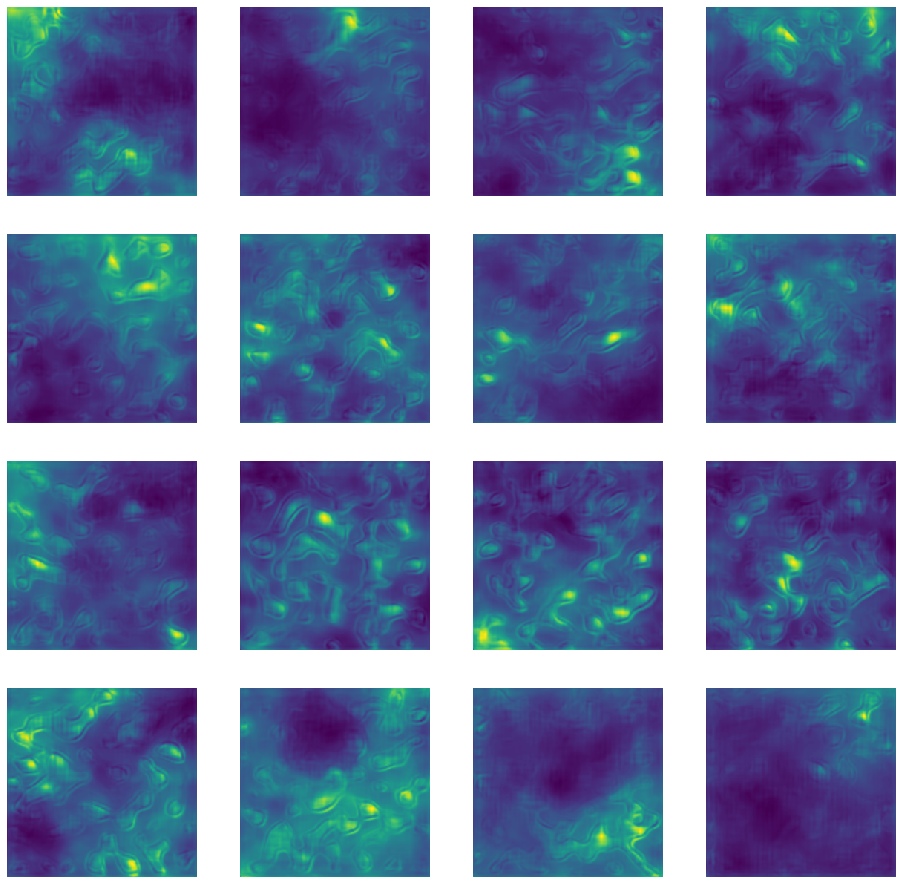

In [133]:
train(train_dataset, EPOCHS)

In [70]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [71]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('plots/image_at_epoch_{:04d}.png'.format(epoch_no))

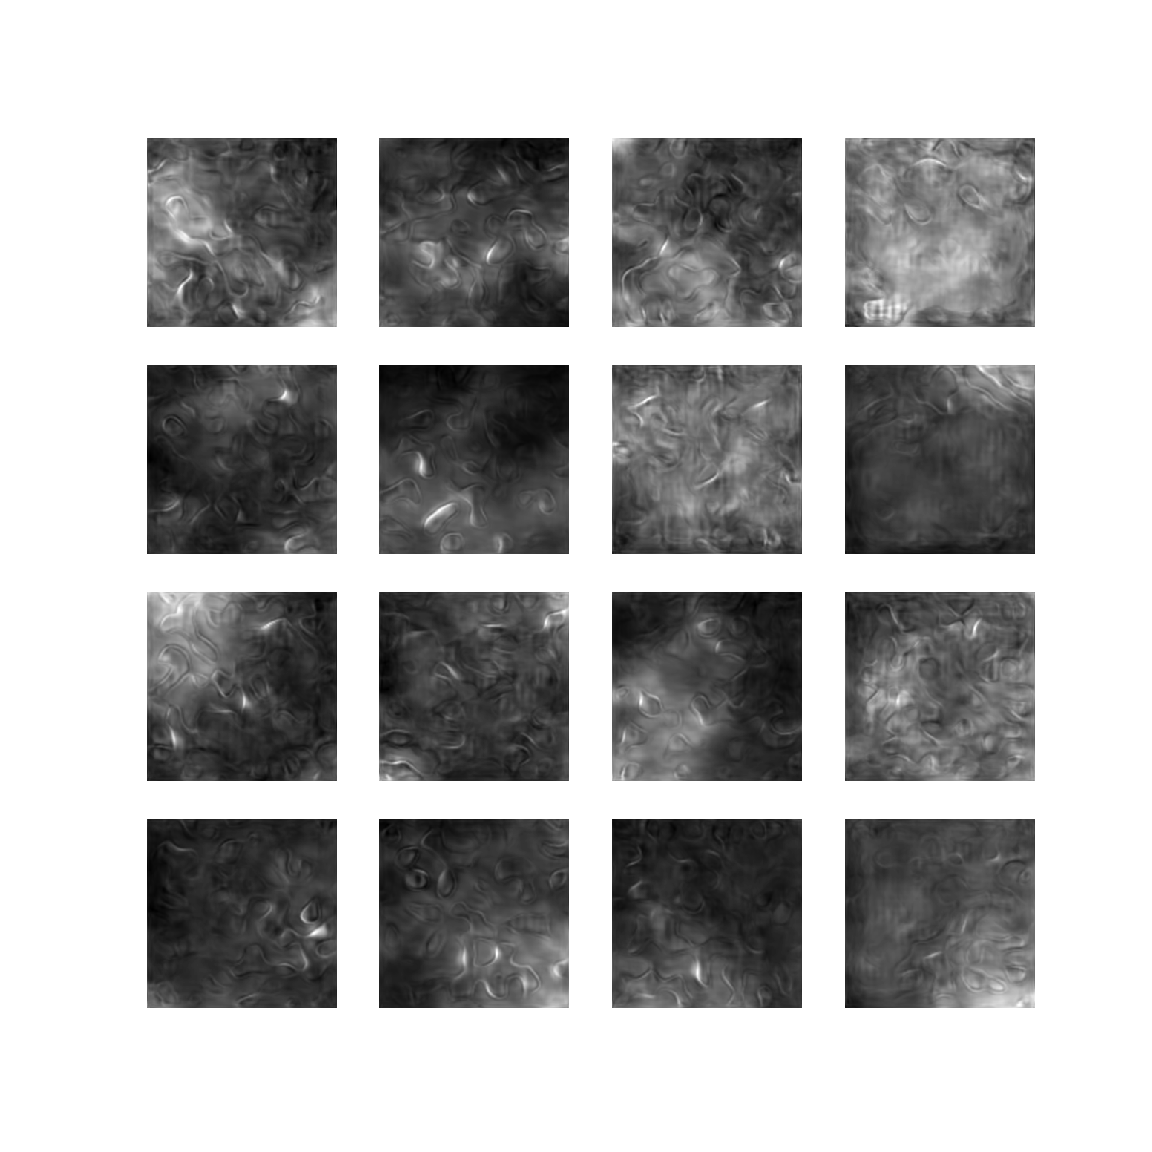

In [72]:
display_image(EPOCHS)

In [73]:
anim_file = 'plots/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('plots/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i, filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

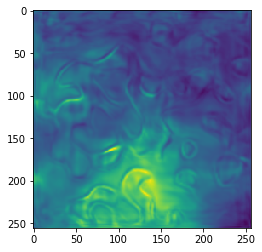

In [75]:
plt.imshow(generator(np.random.randn(1, LAT_DIM))[0, :, :, 0])

NameError: name 'train_image' is not defined

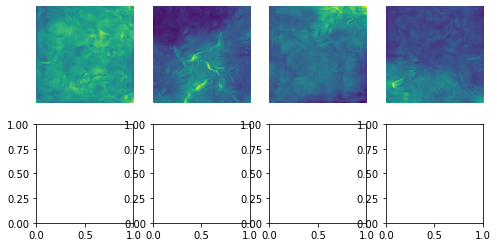

In [76]:
fig, (ax_up, ax_down) = plt.subplots(2, 4, figsize=(8, 4))

for ax in ax_up:
    ax.imshow(generator(np.random.randn(1, LAT_DIM))[0, :, :, 0])
    ax.axis('off')
for ax in ax_down:
    ax.imshow(train_image[np.random.randint(0, 9), :, :, 0])
    ax.axis('off')
fig.savefig("plots/4sample_comparison.pdf", bbox_inches='tight')